In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
file_path = "trajectory.hdf5"
time_step = 0
import bottleneck as bn
with h5py.File(file_path, 'r') as file:
    time_step = file['rafts']['Times'][1] - file['rafts']['Times'][0]

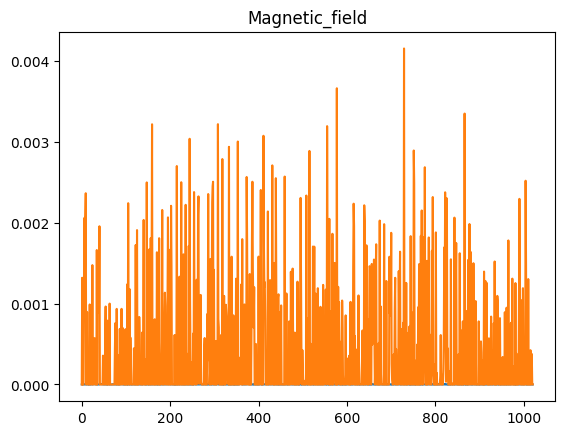

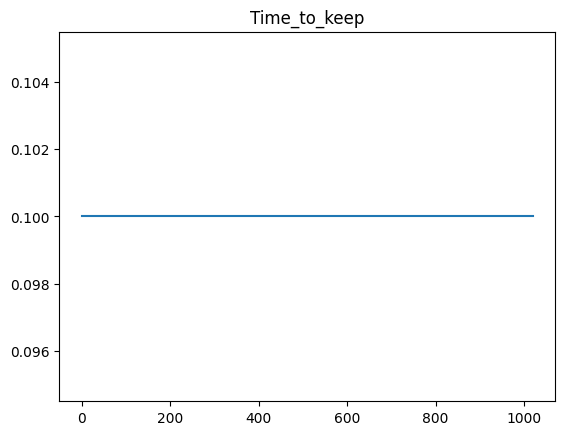

In [6]:
def calculate_rotating_magnetic_field(amplitude, frequency, offset, phase, time):
    return amplitude * np.sin(2 * np.pi * frequency * time + phase) + offset

# Open the HDF5 file

def sine_B_field(calculate_rotating_magnetic_field, time, actions):
    action_chunk = {
        "Amplitudes": actions["Amplitudes"][:],
        "Frequencies": actions["Frequencies"][:],
        "Offsets": actions["Offsets"][:],
        "Phases": actions["Phases"][:],
    }
    
    for key, values in action_chunk.items():
        plt.figure()
        plt.plot(values[:])
        plt.title(key)
        
    plt.figure()
    magnetic_field = calculate_rotating_magnetic_field(
        action_chunk["Amplitudes"],
        action_chunk["Frequencies"],
        action_chunk["Offsets"],
        action_chunk["Phases"],
        time)
        
    plt.plot(time, magnetic_field)
    plt.title('Rotating Magnetic Field')
    plt.xlabel('Time')
    plt.ylabel('Magnetic Field')
    
    plt.figure()
    plt.plot(magnetic_field[-100:,0], magnetic_field[-100:,1])
    plt.title("b field ")

with h5py.File(file_path, 'r') as f:
    # List all groups
    time = f["rafts"]["Times"][:].flatten()
    time = np.array([time,time])
    time = np.transpose(time)
    actions = f["actions"]
    action_chunk = {
        "Magnetic_field": actions["Magnetic_field"][:],
        "Time_to_keep": actions["Time_to_keep"][:],
    }

    for key, values in action_chunk.items():
        plt.figure()
        plt.plot(values[:])
        plt.title(key)

    # plt.figure()
    # dynamic_magnetic_field = []
    # passed_time = 0
    # for i in range(len(action_chunk["Magnetic_field"])):
    #     plt.scatter(passed_time, action_chunk["Magnetic_field"][i][0], c='r')
    #     plt.scatter(passed_time, action_chunk["Magnetic_field"][i][1], c='b')
    #     passed_time += action_chunk["Time_to_keep"][i]
    #     plt.axvline(x=passed_time, color='k', linestyle='--',alpha=0.5)
    #     plt.scatter(passed_time, action_chunk["Magnetic_field"][i][0], c="r")
    #     plt.scatter(passed_time, action_chunk["Magnetic_field"][i][1], c="b")

In [ ]:
with h5py.File(file_path, 'r') as f:
    fig, ax = plt.subplots(2,1)
    direction = np.array(f["rafts"]["Alphas"])
    direction = np.mean(direction, axis=1)
    ax[0].plot(direction.flatten())
    ax[0].set_title("Direction")
    rot_vel = np.array([direction[i+1] - direction[i] for i in range(len(direction)-1)])/(time_step * 2 * np.pi)
    # ax[1].set_ylim(-100,100)
    ax[1].plot(np.squeeze(rot_vel))
    ax[1].set_title("Rotational Velocity [rotations/s]")
    

In [ ]:
from matplotlib.animation import FuncAnimation
with h5py.File(file_path, 'r') as f:
    pos = f["rafts"]["Unwrapped_Positions"][:]
fig, ax = plt.subplots()
ax.set_xlim(0, 10000)
ax.set_ylim(0, 10000)
scat = ax.scatter(pos[0, :, 0], pos[0, :, 1])

def update(frame):
    scat.set_offsets(pos[frame, :, :])
    return scat,

ani = FuncAnimation(fig, update, frames=range(len(pos)), blit=True)
ani.save('trajectory.mp4', writer='ffmpeg', fps=30)

now at -1.1719170706568578, improvement 0.00037088239310811844, improvement last 10% 1.2168853480432062e-07


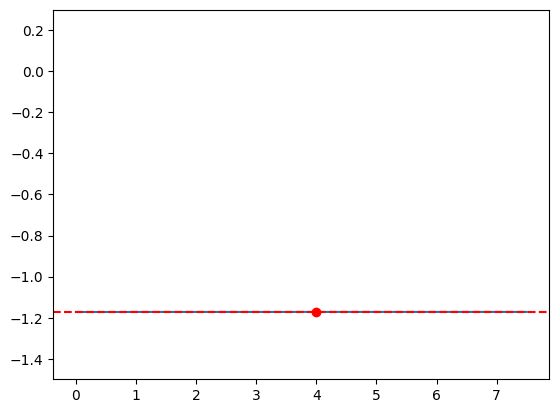

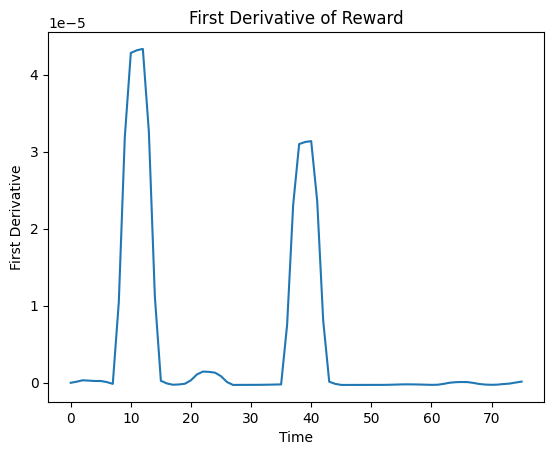

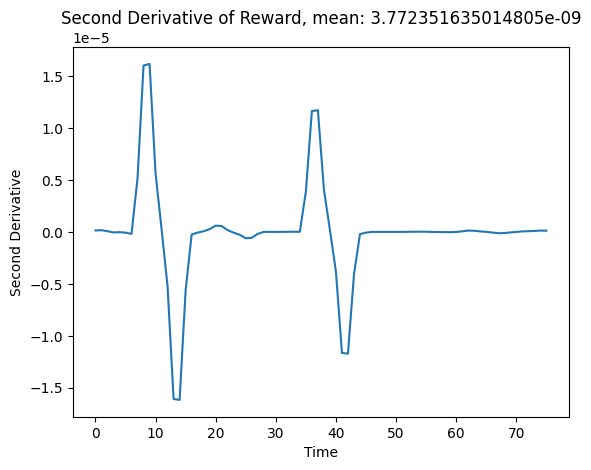

In [3]:
target = np.array([5000, 5000])
with h5py.File(file_path, 'r') as f:
    pos = f["rafts"]["Unwrapped_Positions"]
    time = np.array(f["rafts"]["Times"])
    time = time.flatten()
    reward = -np.linalg.norm(pos - target, axis=2).mean(axis=1)/(0.38*10000)
    reward = bn.move_mean(reward, window=2, min_count=1)
    plt.plot(time, reward)
    plt.axhline(y=reward[0], color="r", linestyle="--")
    plt.plot(np.argmax(reward)* time_step,np.max(reward), 'ro')
    plt.ylim(-1.5, 0.3)
    print(f"now at {reward[-1]}, improvement {reward[-1] - reward[0]}, improvement last 10% {reward[-1] - reward[-len(reward)//10]}")
    reward_first_derivative = np.gradient(bn.move_mean(reward,window=5,min_count=1))
    reward_second_derivative = np.gradient(reward_first_derivative)

    plt.figure()
    plt.plot(reward_first_derivative)
    plt.title('First Derivative of Reward')
    plt.xlabel('Time')
    plt.ylabel('First Derivative')

    plt.figure()
    plt.plot(reward_second_derivative)
    plt.title('Second Derivative of Reward, mean: ' + str(np.mean(reward_second_derivative)))
    plt.xlabel('Time')
    plt.ylabel('Second Derivative')

    plt.show()